# Starbucks dataset

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

# Objective: Predicts whether or not someone will respond to an offer.

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** You may need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because of the version of pandas of some workspace cannot read in the transcript.json file correctly, but the newest version of pandas can.

# Import The libraries

In [1]:
# Set jupyter notebook coding container to fit border of each web browser side 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import math
import json
import time

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline # don't need to call plt.show() when ploting a graph
sns.set()

In [3]:
# Pipeline and GridSearch
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameters
from sklearn.model_selection import cross_val_score

# Outliers
from sklearn.ensemble import IsolationForest


# Data Preparations
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import MinMaxScaler

# Feature Selections
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

# Statistic
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# Model
import xgboost as xgb

# Load The Dataset

In [112]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Functions

In [5]:
def id_mapper(df, column_name, remove_col=False):
    """ 
    Map id with number
    
    Args:
    df: dataframe. The pandas dataframe.
    column_name: string. The column name.
    remove_col: bool. Remove the orginal column or not
    
    Returns:
    offerid_encoded: The removed outliner dataframe by using z score.
    coded_dict: The coded dictionary
    
    """
    coded_dict = dict()
    cter = 1
    id_encoded = []
    
    for val in df[column_name]:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        id_encoded.append(coded_dict[val])
    if remove_col:
        del df[column_name]
    return id_encoded, coded_dict

def z_outlier_filter(df):
    """ 
    Filter outliner by statistic z score.
    
    Args:
    df: dataframe. The pandas dataframe that must contain only numeric values in each column.
    
    Returns:
    filtered_df: The removed outliner dataframe by using z score.
    
    """
    data = df.copy()
    
    #Calculate z-scores
    z_scores = stats.zscore(data)
    abs_z_scores = np.abs(z_scores)
    
    #set NaN to 0
    abs_z_scores[np.isnan(abs_z_scores)]= 0

    #STD method
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    filtered_df = data[filtered_entries]
    return filtered_df

def ML_outlier_filter(df):
    """ 
    Filter outlier by Isolation Forest
    
    Args:
    df: dataframe. The pandas dataframe that must contain only numeric values and not contain any missing values.
    
    Returns:
    anomaly_solved: The removed outlier dataframe by using machine learning (isolationForest).
    
    """
    data = df.copy()
    # Define classifier
    clf = IsolationForest(max_samples=100, random_state = 42, contamination= 'auto')
    data['anomaly'] = clf.fit_predict(data)
    
    # Select the normal datapoints
    anomaly_solved = data[data['anomaly'] == 1]
    anomaly_solved = anomaly_solved.drop('anomaly',axis=1)
    return anomaly_solved

# 1. Data preparation

## 1.1  The portfolio cleaning process 

In [113]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


### Data exploration

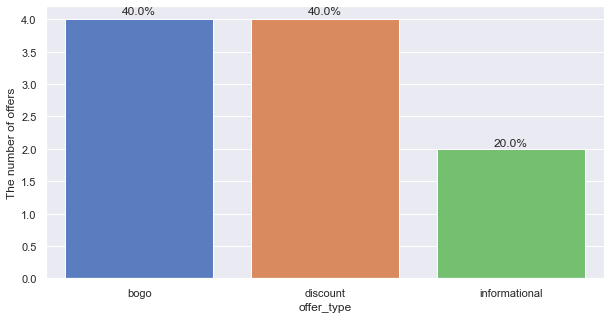

In [114]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(x = 'offer_type', data = portfolio, palette="muted", order = portfolio['offer_type'].value_counts().index)
plt.ylabel('The number of offers')

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(str(round(height/len(portfolio['offer_type'])*100, 2))+'%', (x + width/2, y + height*1.02), ha='center') 

### 1.1.1 Find the columns that have mssing value

In [8]:
# Find the columns that have NaN value
portfolio.columns[portfolio.isna().mean() > 0]

Index([], dtype='object')

### 1.1.2 Dehash hash_id to readable id

In [9]:
# Map hash_id to readable id
encoded_offer_ids, offer_coded_dict = id_mapper(portfolio, 'id')
portfolio['offer_id'] = encoded_offer_ids

### 1.1.3 Create dummies for channels column

In [10]:
# Create the dummies for channels column
channel_dummies = pd.get_dummies(portfolio['channels'].apply(pd.Series).stack()).sum(level=0)
cleaned_portfolio = pd.concat([portfolio, channel_dummies], axis=1)

### 1.1.4 Rename columns

In [11]:
# Rename to make columns more meaningful
cleaned_portfolio.rename({'id': 'hash_offer_id'}, axis = 1, inplace = True)

In [12]:
# Cleaned portfolio
cleaned_portfolio.head()

,reward,channels,difficulty,duration,offer_type,hash_offer_id,offer_id,email,mobile,social,web
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,1,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,2,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,3,1,1,0,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,4,1,1,0,1
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,0,0,1


## 1.2 The profile cleaning process 

In [115]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


### Data exploration

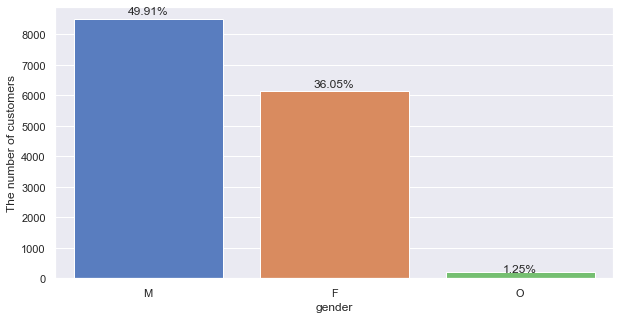

In [116]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(x = 'gender', data = profile, palette="muted", order = profile['gender'].value_counts().index)
plt.ylabel('The number of customers')

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(str(round(height/len(profile['gender'])*100, 2))+'%', (x + width/2, y + height*1.02), ha='center') 

Text(0, 0.5, 'The number of customers')

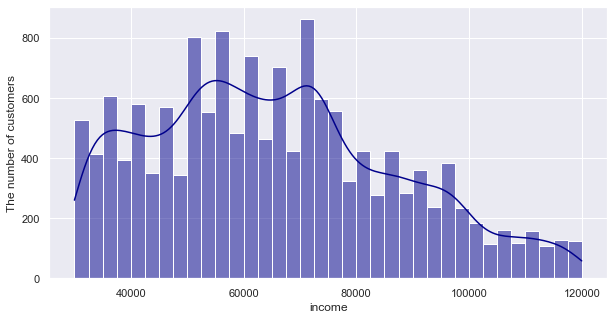

In [139]:
plt.figure(figsize=(10, 5))
sns.histplot(profile['income'], color='darkblue', kde=True)
plt.ylabel('The number of customers')

In [130]:
profile['income'].min(), profile['income'].max()

(30000.0, 120000.0)

Text(0, 0.5, 'The number of customers')

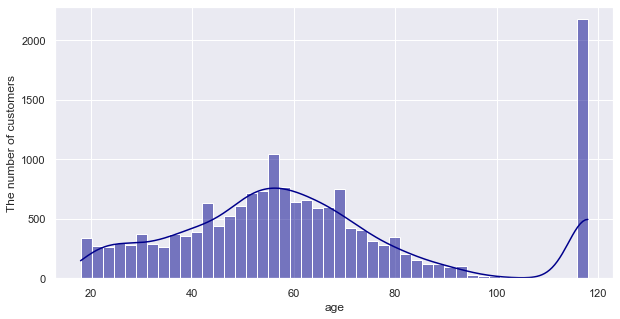

In [117]:
plt.figure(figsize=(10, 5))
sns.histplot(profile['age'], kde=True, color='darkblue')
plt.ylabel('The number of customers')

### 1.2.1 Find the columns that contain missing values

In [17]:
# Find the columns that have missing value value (NaN)
profile.columns[profile.isna().mean() > 0]

Index(['gender', 'income'], dtype='object')

### 1.2.2 Investigate missing values

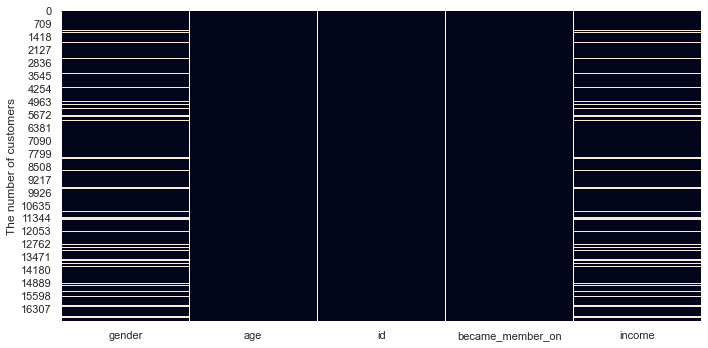

In [179]:
plt.figure(figsize=(10, 5))
ax = sns.heatmap(profile.isnull(), cbar=False)
plt.ylabel('The number of customers')
for i in range(profile.isnull().shape[1]+1):
    ax.axvline(i, color='white', lw=1)
plt.tight_layout()

In [18]:
# Detected the abnormal relationship between income (NaN) and age value (118)
profile[(profile['age'] == 118) & (profile['income'].isna())].head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN


### 1.2.3 Drop missing values
Remove the missing value (NaN) because of abnormal relationship pattern (age=118, gender=None, income=NaN).

In [19]:
# Remove the NaN that come from the abnormal relationship
profile.dropna(subset=['income'], inplace = True)
# Reset index after drop NaN
profile.reset_index(drop=True, inplace=True)

### 1.2.4 Convert date string to date type

In [20]:
# Convert date string to date type
profile.loc[:,'became_member_on'] = pd.to_datetime(profile.loc[:,'became_member_on'], format='%Y%m%d', errors='coerce')

### 1.2.5 Dehash hash_id to readable id

In [21]:
# Map hash_id to readable id
encoded_customer_ids, customer_coded_dict = id_mapper(profile, 'id')
profile['customer_id'] = encoded_customer_ids

### 1.2.6 Rename columns

In [22]:
# Rename to make columns more meaningful
cleaned_profile = profile.rename({'id': 'hash_customer_id'}, axis = 1)

In [23]:
# Cleaned profile
cleaned_profile.head()

,gender,age,hash_customer_id,became_member_on,income,customer_id
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2
2,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,3
3,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,4
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,5


### Data exploration after drop abnormal values

Text(0, 0.5, 'The number of customers')

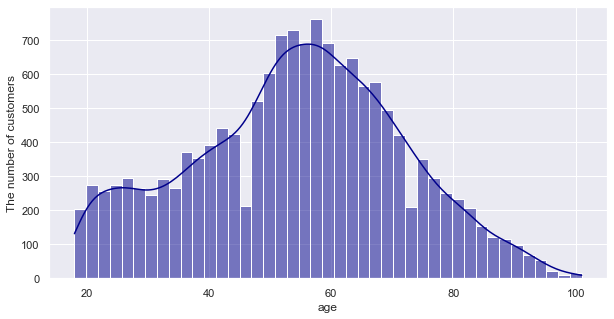

In [120]:
plt.figure(figsize=(10, 5))
sns.histplot(cleaned_profile['age'], kde=True, color='darkblue')
plt.ylabel('The number of customers')

## 1.3 The transcript cleaning process

In [24]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


### Data exploration

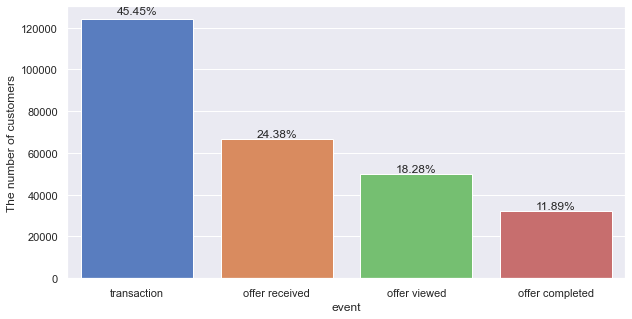

In [111]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(x = 'event', data = transcript, palette="muted", order = transcript['event'].value_counts().index)
plt.ylabel('The number of customers')

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(str(round(height/len(transcript['event'])*100, 2))+'%', (x + width/2, y + height*1.02), ha='center') 

### 1.3.1 Explore the value column
Explore value column which contain json type in transcript dataframe

In [26]:
# Explore value in transcript dataframe
transcript['value']

0         {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2         {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3         {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4         {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
                                ...                       
306529                      {'amount': 1.5899999999999999}
306530                                    {'amount': 9.53}
306531                                    {'amount': 3.61}
306532                      {'amount': 3.5300000000000002}
306533                                    {'amount': 4.05}
Name: value, Length: 306534, dtype: object

### 1.3.2 Drop missing values
Remove unmeaningful customer id (NaN) to reduce cleaning data time

In [29]:
# Remove unmeaningful customer id (NaN) to reduce cleaning data time
# Drop non-exist(abnormal) user
transcript.dropna(subset=['customer_id'], inplace=True)

# Reset index after drop NA
transcript.reset_index(drop=True, inplace=True)

### 1.3.3 Dehash customer id to readable id
Dehash customer id first to reduce data cleaning time.

In [27]:
# Create customer_id column
transcript['customer_id'] = np.nan

# Dehash the person column
# Change hash id to readable id
for idx, value in enumerate(transcript['person']):
    if value in customer_coded_dict:
        transcript.loc[idx,'customer_id'] = customer_coded_dict[value]

In [28]:
transcript['customer_id'].head()

0    2.0
1    NaN
2    3.0
3    NaN
4    NaN
Name: customer_id, dtype: float64

### 1.3.4 Extract variables from value dictionary column
Extract the offer id, reward, and amount values to new columns

In [30]:
# Extract the offer id, reward, and amount value to new columns below
# Declare the desired columns then fill with nan values
transcript['hash_offer_id'] = np.nan
transcript['reward'] = np.nan
transcript['amount'] = np.nan

for i, value in enumerate(transcript['value']):
    if 'reward' in value:
        transcript.loc[i,'reward']  = value['reward']
    if 'offer id' in value:
        transcript.loc[i,'hash_offer_id']  = value['offer id']    
    if 'offer_id' in value:
        transcript.loc[i,'hash_offer_id']  = value['offer_id']
    elif 'amount' in value:
        transcript.loc[i,'amount']  = value['amount']

In [31]:
transcript.head()

,person,event,value,time,customer_id,hash_offer_id,reward,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,2.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,3.0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
2,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,4.0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,5.0,3f207df678b143eea3cee63160fa8bed,NaN,NaN
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,6.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN


### 1.3.5 Dehash hashed offer id to readable id
Map extracted hashed offer_id to readable offer_id

In [32]:
# Map extracted hashed offer_id to readable offer_id
transcript['offer_id'] = np.nan

# Customer_id
for idx, value in enumerate(transcript['hash_offer_id']):
    if value in offer_coded_dict:
        transcript.loc[idx,'offer_id'] = offer_coded_dict[value]

### 1.3.6 Rename columns

In [33]:
# Rename
cleaned_transcript = transcript.rename({'person': 'hash_customer_id', 'value': 'dict_value'}, axis = 1)

In [34]:
# Save dataset for further use to reduce debug time
cleaned_transcript.to_csv('modified_transcript.csv', encoding='utf-8', index=False)

In [35]:
# Load saved dataset
df_transcript = pd.read_csv('modified_transcript.csv')
df_transcript.head()

,hash_customer_id,event,dict_value,time,customer_id,hash_offer_id,reward,amount,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,2.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,4.0
1,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,3.0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,10.0
2,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,4.0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,9.0
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,5.0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,3.0
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,6.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,5.0


## 1.4 Create training dataset from three datasets from cleaned datasets above 

## Find the offer that customer responds.
- Offers are responded when customer both viewed and completed the offer.

### 1.4.1 Select non-transaction events

In [36]:
# Fetch the non-transaction events
offer_transcript = cleaned_transcript[cleaned_transcript['event'] != 'transaction'].drop('amount', axis=1)
# Reset index after drop the transaction event
offer_transcript.reset_index(drop=True, inplace=True)
offer_transcript.head()

,hash_customer_id,event,dict_value,time,customer_id,hash_offer_id,reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,2.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,4.0
1,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,3.0,2906b810c7d4411798c6938adc9daaa5,NaN,10.0
2,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,4.0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,9.0
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,5.0,3f207df678b143eea3cee63160fa8bed,NaN,3.0
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,6.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,5.0


In [37]:
# Sort the offers by customer_id and time, sequentially
sorted_offers = offer_transcript.sort_values(by=['customer_id','time'])

# Create unique customer id to iterate a for loop
unique_custid = sorted_offers['customer_id'].astype(int).unique()

# The dictionaries that match between the customer id and the list of offer ids
responsed_dict = dict() 
offer_dict = dict() 

for custid in unique_custid:
    received_offer = []
    track_viewed_offer = []
    responsed_offer = []
    
    # Select dataframe of specific customer id
    df_offers = offer_transcript[offer_transcript['customer_id'] == custid]
    df_offers.reset_index(drop=True,inplace=True)
    
    for idx, event in enumerate(df_offers['event']):
        if event == 'offer received':
            # Store the recieved offer
            received_offer.append(df_offers.loc[idx, 'offer_id'])
        elif event == 'offer viewed':
            # if offer is not in track_viewed_offer add it
            if not df_offers.loc[idx, 'offer_id'] in track_viewed_offer:
                track_viewed_offer.append(df_offers.loc[idx, 'offer_id'])
        elif event == 'offer completed':
            # Offer are responded when customer both view the offer and then completed offer
            if df_offers.loc[idx, 'offer_id'] in track_viewed_offer:
                responsed_offer.append(df_offers.loc[idx, 'offer_id'])
                track_viewed_offer.remove(df_offers.loc[idx, 'offer_id'])
                
    # Create dictionaries for current customer_id
    responsed_dict[custid] = responsed_offer # the offers that are responsed by current customer id
    offer_dict[custid] = received_offer # the offers that give to current customer id 

### 1.4.2 Create a training dataset by using the dictionaries
- responsed_dict: The dictionary between customer_id and the list of responsed offer
- offer_dict: The dictionary between customer_id and the list of viewed offer

In [38]:
# Check the responsed_dict
dict(list(responsed_dict.items())[:5])

{1: [], 2: [4.0, 1.0], 3: [4.0, 7.0], 4: [9.0, 10.0, 4.0, 9.0, 7.0], 5: [7.0]}

In [39]:
# Check the offer_dict
dict(list(offer_dict.items())[:5])

{1: [4.0, 3.0],
 2: [4.0, 8.0, 1.0, 9.0],
 3: [10.0, 3.0, 4.0, 7.0],
 4: [9.0, 4.0, 10.0, 4.0, 9.0, 7.0],
 5: [3.0, 6.0, 7.0]}

In [40]:
# Create response (target) columns by dictionaries above then merge datasets
cleaned_profile['response'] = np.nan

#The number of offer
num=0

# For each customer id 
for custid in offer_dict:
    for offer_id in offer_dict[custid]:
        # Select profile dataset that has customer id ...
        df_profile = cleaned_profile[cleaned_profile['customer_id'] == custid].reset_index(drop=True)
        df_portfolio = cleaned_portfolio[cleaned_portfolio['offer_id'] == offer_id].reset_index(drop=True)
        if num==0:
            features = pd.concat([df_profile,df_portfolio], axis=1)
        else:
            new_features = pd.concat([df_profile,df_portfolio], axis=1)
            features = pd.concat([features,new_features], axis=0).reset_index(drop=True)
        # Assign response or not response to column
        if offer_id in responsed_dict[custid]:
            features.loc[num, 'response'] = 1
        else:
            #print(i)
            features.loc[num, 'response'] = 0
        num+=1
features.head()

,gender,age,hash_customer_id,became_member_on,income,customer_id,response,reward,channels,difficulty,duration,offer_type,hash_offer_id,offer_id,email,mobile,social,web
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,0.0,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,4,1,1,0,1
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,0.0,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,3,1,1,0,1
2,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2,1.0,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,4,1,1,0,1
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2,0.0,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,8,1,1,1,0
4,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2,1.0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,1,0


In [41]:
# Save the dataset to reduce debug time
features.to_csv('features.csv', encoding='utf-8', index=False)

In [42]:
# Load the saved dataset
df_features = pd.read_csv('features.csv')
df_features.head()

,gender,age,hash_customer_id,became_member_on,income,customer_id,response,reward,channels,difficulty,duration,offer_type,hash_offer_id,offer_id,email,mobile,social,web
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,0.0,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,4,1,1,0,1
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,0.0,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed,3,1,1,0,1
2,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2,1.0,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,4,1,1,0,1
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2,0.0,0,"['email', 'mobile', 'social']",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,8,1,1,1,0
4,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2,1.0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,1,0


## 1.5 Clean training dataset

### 1.5.1 Drop unuseful columns
- channels: JSON format doesn't provide useful information.
- hash_offer_id: Duplicates with offer_id hashed value.
- id columns: Not provide a meaningful analysis.
- became_member_on: Doesn't use to analysis

In [43]:
# Select columns according to the list
cols = ['gender','age','income','reward','difficulty',
        'duration','offer_type','email','mobile','social','web','response']
df = df_features.loc[:, cols]
df.head()

,gender,age,income,reward,difficulty,duration,offer_type,email,mobile,social,web,response
0,F,55,112000.0,5,5,7,bogo,1,1,0,1,0.0
1,F,55,112000.0,0,0,4,informational,1,1,0,1,0.0
2,F,75,100000.0,5,5,7,bogo,1,1,0,1,1.0
3,F,75,100000.0,0,0,3,informational,1,1,1,0,0.0
4,F,75,100000.0,10,10,7,bogo,1,1,1,0,1.0


### 1.5.2 Remove column that has missing values more than the threshold in percentage

In [44]:
# Remove column that has missing values more than the threshold in percentage
mis_columns = df.columns[df.isnull().mean()>0.75]
df.drop(mis_columns, axis=1, inplace=True)
df.head()

,gender,age,income,reward,difficulty,duration,offer_type,email,mobile,social,web,response
0,F,55,112000.0,5,5,7,bogo,1,1,0,1,0.0
1,F,55,112000.0,0,0,4,informational,1,1,0,1,0.0
2,F,75,100000.0,5,5,7,bogo,1,1,0,1,1.0
3,F,75,100000.0,0,0,3,informational,1,1,1,0,0.0
4,F,75,100000.0,10,10,7,bogo,1,1,1,0,1.0


### 1.5.3 Explore data distributions

<AxesSubplot:xlabel='age', ylabel='Count'>

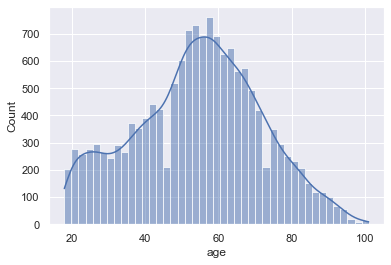

In [45]:
#plt.figure(figsize=(10, 5))
sns.histplot(profile['age'], kde=True)

<AxesSubplot:xlabel='income', ylabel='Count'>

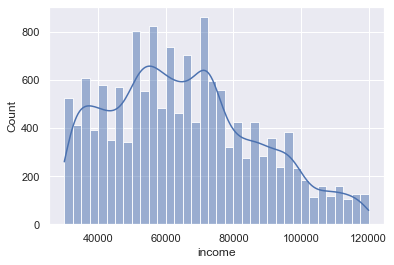

In [46]:
sns.histplot(profile['income'], kde=True)

<AxesSubplot:xlabel='gender', ylabel='count'>

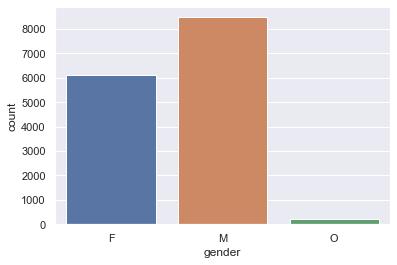

In [47]:
sns.countplot(x = 'gender', data = profile)

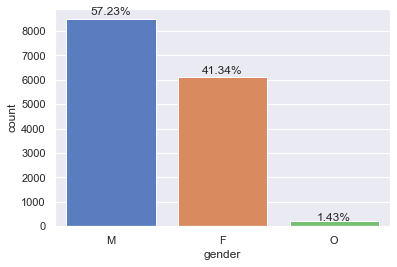

In [48]:
ax = sns.countplot(x = 'gender', data = profile, palette="muted", order = profile['gender'].value_counts().index)

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(str(round(height/len(profile['gender'])*100, 2))+'%', (x + width/2, y + height*1.02), ha='center')

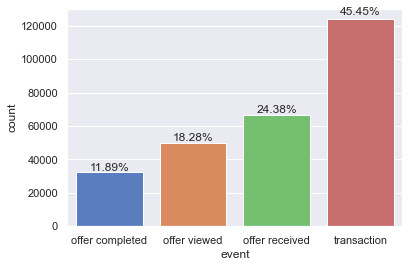

In [49]:
ax = sns.countplot(x = 'event', data = transcript, palette="muted", order = transcript['event'].value_counts(ascending=True).index)

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(str(round(height/len(transcript['event'])*100, 2))+'%', (x + width/2, y + height*1.02), ha='center') 

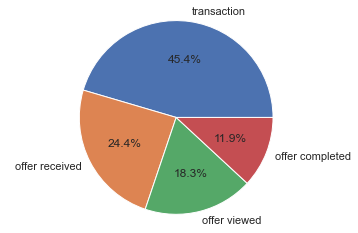

In [50]:
labels = list(transcript['event'].value_counts().index)
sizes = list(transcript['event'].value_counts().values)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels,autopct='%1.1f%%')
ax1.axis('equal')
plt.show()

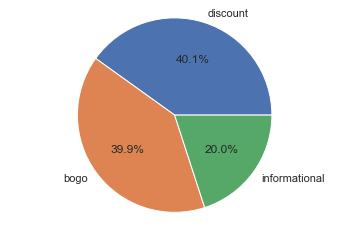

In [51]:
labels = list(df['offer_type'].value_counts().index)
sizes = list(df['offer_type'].value_counts().values)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels,autopct='%1.1f%%')
ax1.axis('equal')
plt.show()

<AxesSubplot:xlabel='offer_type', ylabel='count'>

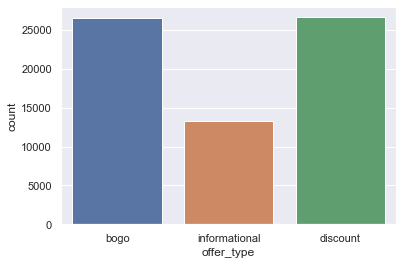

In [52]:
sns.countplot(x = 'offer_type', data = df)

### 1.5.4 Remove outliers
An outlier is a crucial problem that makes our model inaccurate and inefficient. we should handle it before performing any actor that relates to machine learning or modeling.

### Separate numeric and non-numeric columns/features
- Because we only remove outiler for numeric type

In [53]:
# Separate columns to remove outlier and not remove outlier.
remove_outlier = df[['age','income']]
not_remove_outlier = df.drop(['age','income'],axis=1)

### The statistic z-score
- Filter outliner by statistic z score.

In [54]:
# Remove outliers by statistic z-score method
z_anomaly_solved = z_outlier_filter(remove_outlier)

### Isolation Forest
- Isolation Forest is an outlier detection technique that identifies anomalies instead of normal observations
- The Isolation Forest isolate observations into abnormal vs normal observations by the following step:
<br><img src="images/Isolation_forest_pic.png" align="left"/>

- At each node in the decision tree, randomly select a feature then selecting a splitting value between maximum and minimum values of the selected feature/column to split the dataset into two.
- After that, keep doing the above step until all observations are isolated from each other.
- The anomalies are detected by finding the observation that is isolated faster or easier than other observations because the anomalies are normally far from normal observations.

In [55]:
# Remove outliers by manchine learning method
anomaly_solved = ML_outlier_filter(z_anomaly_solved)

### Merge data after remove outlier

In [56]:
# Combine numeric features and catergorical features
not_remove_outlier_df = pd.DataFrame(not_remove_outlier,index = anomaly_solved.index)
removed_outlier = pd.concat([not_remove_outlier_df, anomaly_solved], axis=1)

# Reset index after dropped the rows that contain missing values
removed_outlier.reset_index(drop=True, inplace=True)
removed_outlier.shape

(38144, 12)

### Compare before and after removed outliner 

/Users/alicis/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='income', ylabel='Density'>

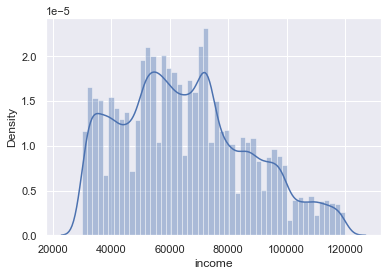

In [57]:
# Before
sns.distplot(df['income'])

/Users/alicis/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='income', ylabel='Density'>

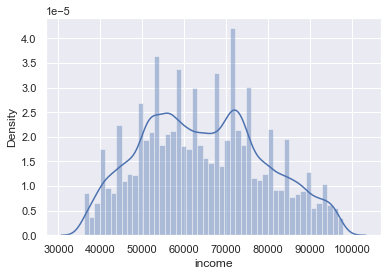

In [58]:
# After
sns.distplot(removed_outlier['income'])

# 2. Build a Model

## 2.1 Apply One-hot encoding on categorical columns

In [59]:
# Drop a target column
df_features = removed_outlier.drop('response', axis=1)

# Apply One-hot encoding on categorical columns
features_encoded = pd.get_dummies(df_features, columns=['gender','offer_type'])

## 2.2 Declare X (features) and y (target)

In [60]:
# Declare a target
y = removed_outlier['response'].copy().astype(int)

# Declare features
X = features_encoded.copy()
X.head()

,reward,difficulty,duration,email,mobile,social,web,age,income,gender_F,gender_M,gender_O,offer_type_bogo,offer_type_discount,offer_type_informational
0,2,10,7,1,1,0,1,68,70000.0,0,1,0,0,1,0
1,0,0,4,1,1,0,1,68,70000.0,0,1,0,0,0,1
2,5,5,7,1,1,0,1,68,70000.0,0,1,0,1,0,0
3,2,10,10,1,1,1,1,68,70000.0,0,1,0,0,1,0
4,5,5,5,1,1,1,1,65,53000.0,0,1,0,1,0,0


In [61]:
# Check 1:0 ratio
sum(y)/len(y)

0.41062814597315433

## 2.3 Split the data to training and testing data

In [62]:
# Split the data to training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [63]:
sum(y_train)/len(y_train)

0.4106194071588367

In [64]:
X_train.head()

,reward,difficulty,duration,email,mobile,social,web,age,income,gender_F,gender_M,gender_O,offer_type_bogo,offer_type_discount,offer_type_informational
26624,5,5,5,1,1,1,1,67,43000.0,0,1,0,1,0,0
5304,5,5,7,1,1,0,1,44,74000.0,1,0,0,1,0,0
24815,0,0,3,1,1,1,0,65,70000.0,0,1,0,0,0,1
24412,5,5,5,1,1,1,1,59,55000.0,1,0,0,1,0,0
290,10,10,7,1,1,1,0,55,94000.0,1,0,0,1,0,0


## 2.4 Build and train XGBoost Classifier model for predict the response

In [65]:
# GridSearch for finding hyperparameters
# ROUND 1
param_grid = {
    'max_depth': [3, 4, 5], # Tree depth
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma': [0,0.25,1.0],
    'reg_lambda': [0, 1.0, 10.0],
    'scale_pos_weight': [1, 3, 5]
}

# Optimizing
optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic', seed=42),
    param_grid=param_grid,
    scoring = 'roc_auc',
    verbose=2,
    n_jobs = -1)

optimal_params.fit(X_train,
                y_train,
                verbose=False, # Do not print the process
                early_stopping_rounds=10,
                eval_metric='auc',
                eval_set=[(X_test, y_test)])
print(optimal_params.best_params_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1215 out of 1215 | elapsed:  3.9min finished


{'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 0, 'scale_pos_weight': 3}


In [66]:
# ROUND 2
param_grid = {
    'max_depth': [3, 4, 5], # Tree depth
    'learning_rate': [0.05, 0.1],
    'gamma': [0],
    'reg_lambda': [0],
    'scale_pos_weight': [1]
}

# Optimizing
optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic', seed=42),
    param_grid=param_grid,
    scoring = 'roc_auc',
    verbose=2,
    n_jobs = -1)

optimal_params.fit(X_train,
                y_train,
                verbose=False, # Do not print the process
                early_stopping_rounds=10,
                eval_metric='auc',
                eval_set=[(X_test, y_test)])
print(optimal_params.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    6.1s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.7s finished


{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 0, 'scale_pos_weight': 1}


In [191]:
optimal_params.fit(X_train,
            y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric='auc',
            eval_set=[(X_test, y_test)])

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    6.6s remaining:    2.0s


[0]	validation_0-auc:0.79102
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.79167
[2]	validation_0-auc:0.79196
[3]	validation_0-auc:0.79296
[4]	validation_0-auc:0.79295
[5]	validation_0-auc:0.79356
[6]	validation_0-auc:0.79542


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.4s finished


[7]	validation_0-auc:0.79544
[8]	validation_0-auc:0.79554
[9]	validation_0-auc:0.79559
[10]	validation_0-auc:0.79567
[11]	validation_0-auc:0.79633
[12]	validation_0-auc:0.79648
[13]	validation_0-auc:0.79668
[14]	validation_0-auc:0.79690
[15]	validation_0-auc:0.79699
[16]	validation_0-auc:0.79717
[17]	validation_0-auc:0.79724
[18]	validation_0-auc:0.79722
[19]	validation_0-auc:0.79735
[20]	validation_0-auc:0.79749
[21]	validation_0-auc:0.79766
[22]	validation_0-auc:0.79783
[23]	validation_0-auc:0.79800
[24]	validation_0-auc:0.79806
[25]	validation_0-auc:0.79810
[26]	validation_0-auc:0.79820
[27]	validation_0-auc:0.79844
[28]	validation_0-auc:0.79859
[29]	validation_0-auc:0.79857
[30]	validation_0-auc:0.79866
[31]	validation_0-auc:0.79865
[32]	validation_0-auc:0.79874
[33]	validation_0-auc:0.79889
[34]	validation_0-auc:0.79904
[35]	validation_0-auc:0.79901
[36]	validation_0-auc:0.79908
[37]	validation_0-auc:0.79928
[38]	validation_0-auc:0.79946
[39]	validation_0-auc:0.79951
[40]	validati

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=42,
                                     subsample=None, tree_method=None,
         

## 2.5 Plot a confusion matrix 

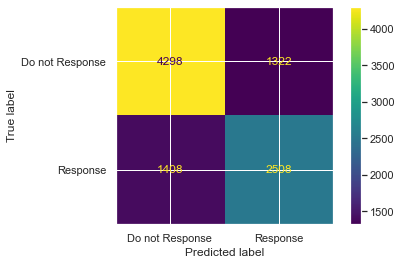

In [190]:
# Plot confusion matrix 
plot_confusion_matrix(optimal_params,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=['Do not Response','Response'])

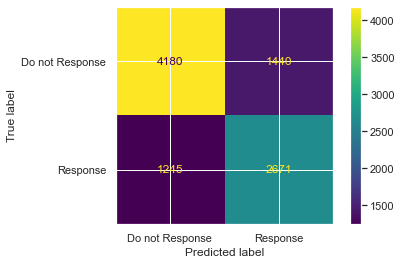

In [192]:
# Plot confusion matrix 
plot_confusion_matrix(optimal_params,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=['Do not Response','Response'])

In [186]:
y_test.value_counts()

0    5620
1    3916
Name: response, dtype: int64

In [197]:
y_test.shape

(9536,)

In [195]:
1440/(4180+1440)

0.25622775800711745

In [196]:
4180/(1245+4180)

0.7705069124423963

In [69]:
4188/(4188+1407)

0.7485254691689008

In [70]:
2608/(1347+2608)

0.6594184576485461

In [71]:
4188/(1347+4188)

0.756639566395664